In [37]:
import NuRadioReco.modules.io.eventReader
from NuRadioReco.framework.parameters import particleParameters as pp

event_reader = NuRadioReco.modules.io.eventReader.eventReader()

file = 'output.nur'
event_reader.begin(file)
for iE, event in enumerate(event_reader.run()):
    primary = event.get_primary()
    for iStation, station in enumerate(event.get_stations()):
        print(f"primary id: {primary.get_id()}, {station.get_id()}")


primary id: 11, 101
primary id: 14, 104
primary id: 21, 101
primary id: 36, 102
primary id: 76, 102
primary id: 76, 103
primary id: 79, 101
primary id: 139, 102
primary id: 139, 104
primary id: 140, 103
primary id: 166, 101
primary id: 166, 103
primary id: 249, 102
primary id: 249, 104
primary id: 251, 102
primary id: 251, 104
primary id: 309, 103
primary id: 320, 101
primary id: 333, 104
primary id: 342, 102
primary id: 418, 101
primary id: 436, 103
primary id: 438, 101
primary id: 464, 104
primary id: 494, 104
primary id: 518, 101
primary id: 518, 103
primary id: 560, 104
primary id: 623, 103
primary id: 623, 104
primary id: 633, 103
primary id: 657, 102
primary id: 681, 101
primary id: 681, 102
primary id: 681, 104
primary id: 693, 101
primary id: 693, 104
primary id: 701, 102
primary id: 720, 101
primary id: 720, 103
primary id: 726, 102
primary id: 726, 103
primary id: 817, 101
primary id: 817, 103
primary id: 835, 103
primary id: 841, 104
primary id: 894, 104
primary id: 906, 102

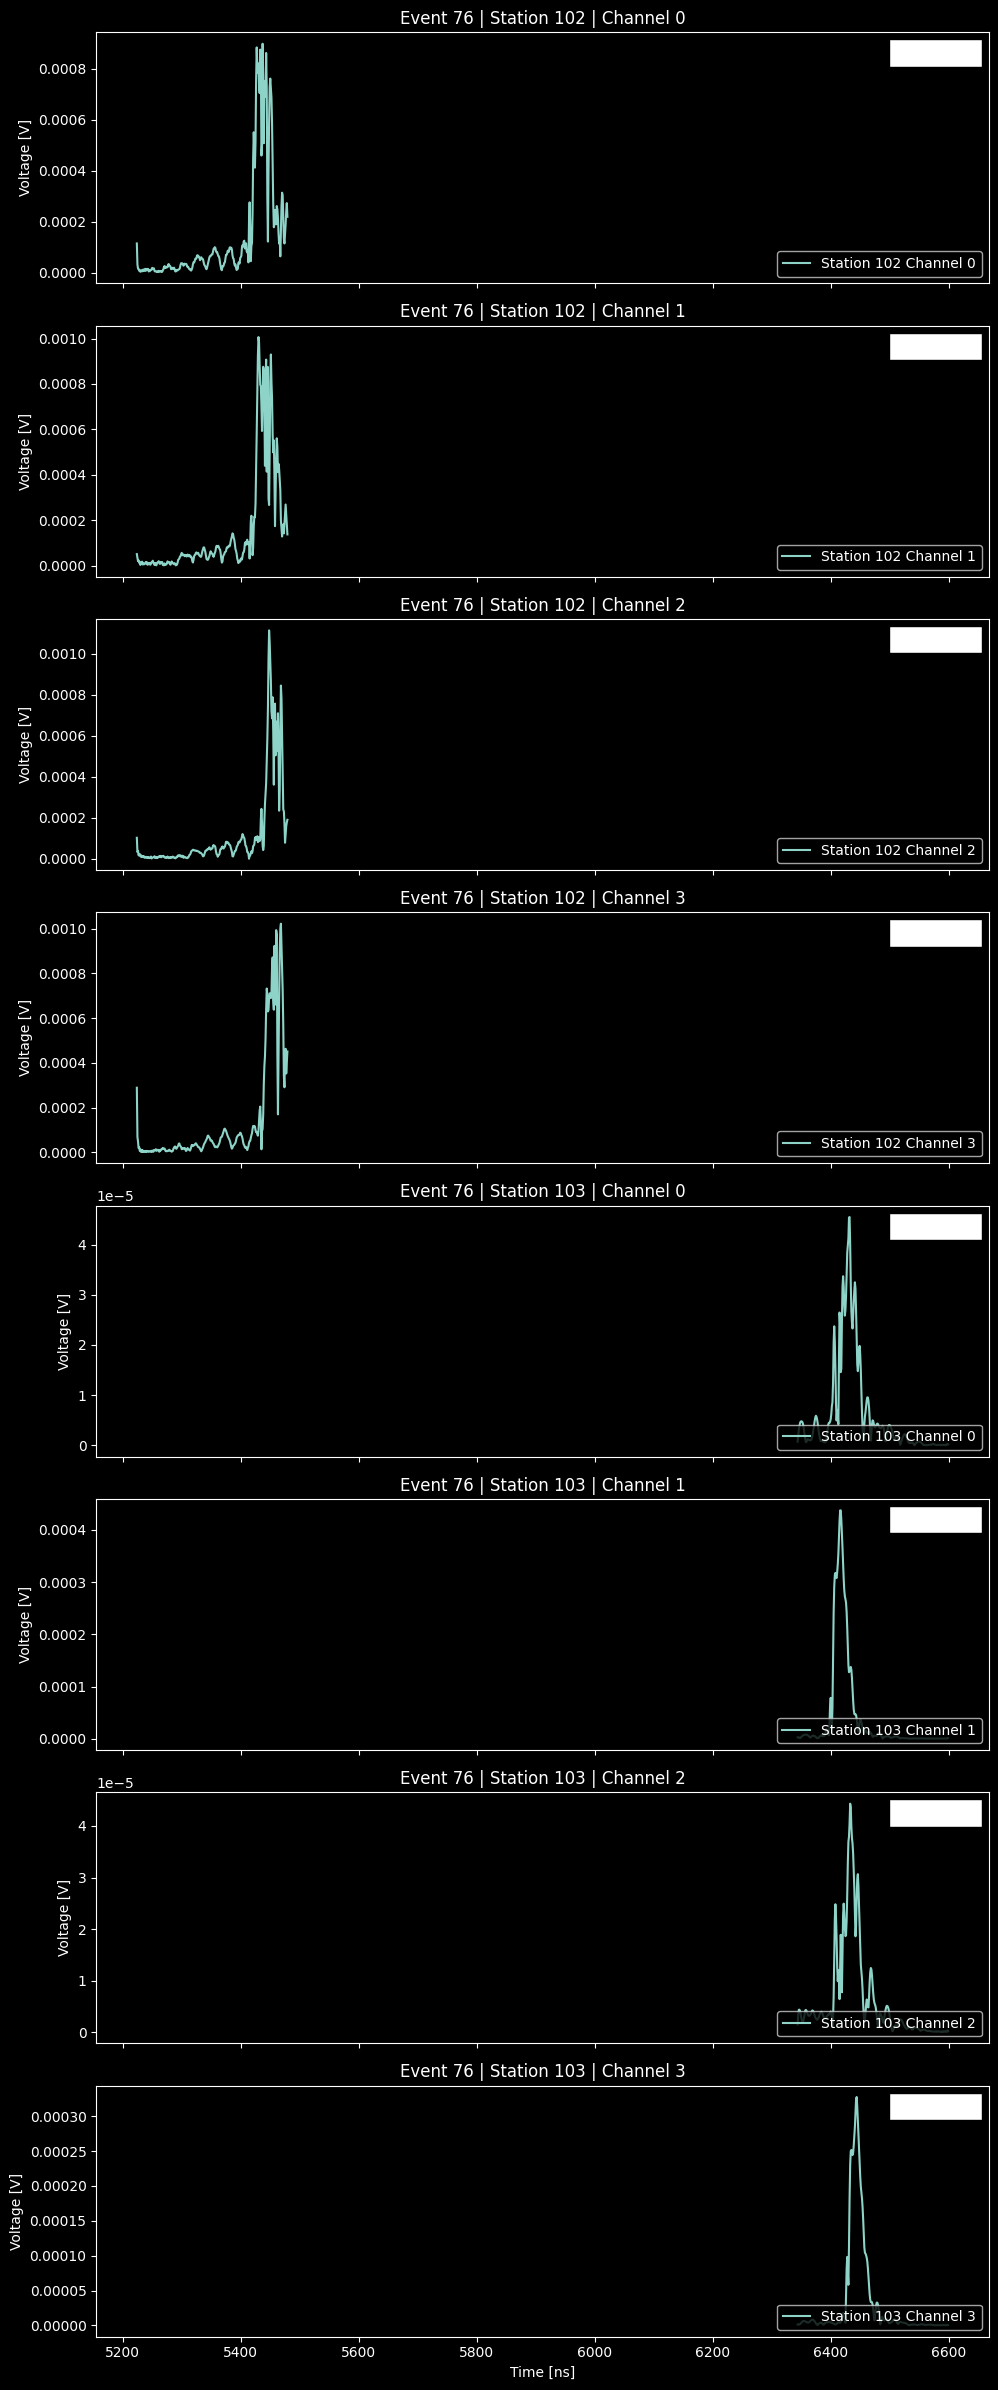

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import NuRadioReco.modules.io.eventReader
# plt.style.use('dark_background')

def get_unique_events(fPath):
    """
    Reads a NuRadioReco .nur file and returns a list of unique events, 
    where each event contains all stations that detected the same primary particle.

    This function iterates through all events in the file, groups together 
    stations that correspond to the same primary particle (using the primary particle ID), 
    and constructs a list of unique events, each with all associated stations.

    Parameters
    ----------
    fPath : str
        Path to the .nur file to be read.

    Returns
    -------
    events_unique : list of NuRadioReco.framework.event.Event
        List of unique events, each containing all stations that saw the same primary particle.

    Notes
    -----
    - The function assumes that the eventReader yields events in order of primary particle ID.
    - For each new primary particle ID, a new event is started and stations are added to it.
    - The function will output events with event ID equal to the particle ID they correspond to.
    """
    event_reader = NuRadioReco.modules.io.eventReader.eventReader()
    event_reader.begin(fPath)
    events_unique = []
    iFirst = -1
    first_event = None
    for iE, event in enumerate(event_reader.run()):
        primary = event.get_primary()
        iP = primary.get_id()
        event.set_id(iP)

        # Start a new unique first event if the primary ID changes
        if iFirst != event.get_id():
            if first_event is not None:
                events_unique.append(first_event)
            iFirst = event.get_id()
            first_event = event
        # Add stations from the same primary to the current first event
        if event is not first_event:    
            first_event.set_station(event.get_station())

    return events_unique

events_unique = get_unique_events('output.nur')

# for event in events_unique:
#     print(event.get_id())
#     print(f"Number of stations: {len(list(event.get_stations()))}")

##############################################################


for iE, event in enumerate(events_unique):
    if iE != 4:
        continue
    stations = list(event.get_stations())
    stations_num = len(stations)
    # Get the number of channels for each station (assuming all stations have the same number of channels)
    channels_per_station = [len(list(station.iter_channels())) for station in stations]
    total_channels = sum(channels_per_station)

    fig, axs = plt.subplots(total_channels, 1, figsize=(10, 3 * total_channels), sharex=True)
    if total_channels == 1:
        axs = [axs]

    ax_idx = 0
    for iStation, station in enumerate(stations):
        for ch in station.iter_channels():
            volts = ch.get_hilbert_envelope()
            times = ch.get_times()
            tot_time = (times[-1] - times[0]) + 1 # Have to add one ns because first element starts at 1 ns.
            tot_time_box = AnchoredText(f'$t_{{tot}}:$ {int(tot_time)} ns',loc=1)
            axs[ax_idx].add_artist(tot_time_box)
            axs[ax_idx].plot(times, volts, label=f'Station {station.get_id()} Channel {ch.get_id()}')
            axs[ax_idx].set_title(f"Event {event.get_id()} | Station {station.get_id()} | Channel {ch.get_id()}")
            axs[ax_idx].set_ylabel("Voltage [V]")
            axs[ax_idx].legend(loc=4)
            ax_idx += 1

    print(f'Saving trace for particle {event.get_id()} fields, detected at Station {station.get_id()}')
    fig.savefig(f"particle:{event.get_id()}_station:{station.get_id()}.png") # save the traces
    plt.close(fig)


In [39]:
for iE, event in enumerate(event_reader.run()):
    primary = event.get_primary()
    iP = primary.get_id()

    for iStation, station in enumerate(event.get_stations()):
        stations = list(event.get_stations())
        stations_num = len(stations)
        channels = list(station.iter_channels())
        channels_num = len(channels)

        # a fig and axes for our waveforms
        fig, axs = plt.subplots(stations_num*channels_num, 1, figsize=(5,20)) # subplots will scale with num of total channels

        # this loops through "mock data" (with noise added, etc.)
        for ch in station.iter_channels():
            volts = ch.get_trace()
            times = ch.get_times()
            tot_time = (times[-1] - times[0]) + 1 # Have to add one ns because first element starts at 1 ns.
            tot_time_box = AnchoredText(f'$t_{{tot}}:$ {int(tot_time)} ns',loc=1)
            axs[ch.get_id()].add_artist(tot_time_box) # Add total time of trace (Only calculated for true V, but should be the same regardless)
            axs[ch.get_id()].plot(times, volts, label='V') # type: ignore
            axs[ch.get_id()].set_title(f"Particle number {iP} | Station {station.get_id()}, Channel {ch.get_id()}") # type: ignore
        
        # this loops through *MC truth* waveforms (before noise was added)
        # this may prove useful at some point
        if station.has_sim_station():
            sim_station = station.get_sim_station()
            for sim_ch in sim_station.iter_channels():
                volts = sim_ch.get_trace()
                times = sim_ch.get_times()
                if sim_ch.get_ray_tracing_solution_id() == 0: # If else check to add direct and reflected traces.
                    axs[sim_ch.get_id()].plot(times, volts, '--',label=f'Vsim direct',color='tab:green') # type: ignore
                else:
                    axs[sim_ch.get_id()].plot(times, volts, '--',label=f'Vsim reflected',color='tab:red') # type: ignore

        # Note, for station and sim station to line-up set the pre_trigger_time to 0 ns.

        for ax in axs:
            ax.set_xlabel("Time [ns]")
            ax.set_ylabel("Voltage [V]")
            ax.legend(loc=4)

        plt.tight_layout()

        print(f'Saving trace for particle {iP} fields, detected at Station {station.get_id()}')
        fig.savefig(f"particle:{iP}_station:{station.get_id()}.png") # save the traces
        plt.close(fig)

Saving trace for particle 11 fields, detected at Station 101
Saving trace for particle 14 fields, detected at Station 104
Saving trace for particle 21 fields, detected at Station 101
Saving trace for particle 36 fields, detected at Station 102
Saving trace for particle 76 fields, detected at Station 102
Saving trace for particle 76 fields, detected at Station 103
Saving trace for particle 79 fields, detected at Station 101
Saving trace for particle 139 fields, detected at Station 102
Saving trace for particle 139 fields, detected at Station 104
Saving trace for particle 140 fields, detected at Station 103
Saving trace for particle 166 fields, detected at Station 101
Saving trace for particle 166 fields, detected at Station 103
Saving trace for particle 249 fields, detected at Station 102
Saving trace for particle 249 fields, detected at Station 104
Saving trace for particle 251 fields, detected at Station 102
Saving trace for particle 251 fields, detected at Station 104
Saving trace fo